In [1]:
import sys
sys.path.insert(0, '../archaeology')
sys.path.insert(0, '../analysis')
from math import floor, ceil, isnan
from collections import defaultdict, Counter
from pprint import pprint

import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from IPython.display import display
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from db import connect, Repository, Notebook, Query
import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import dask_from_query, cell_distribution
from analysis_helpers import display_counts, violinplot, describe_processed
from analysis_helpers import distribution_with_boxplot
from analysis_helpers import var, relative_var, savefig
from analysis_helpers import calculate_auto, close_fig, print_result
from analysis_helpers_general import display_barchart
from analysis_helpers_executions import get_combined_reason

%matplotlib inline

In [2]:
def display_plotlybar(df, x, y, filename, yaxis_type='log'):
    fig = px.bar(df, x, y, text=y)
    fig.update_traces(texttemplate='%{text:s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, yaxis_type=yaxis_type)
    fig.write_image('Trends/' + filename + '.pdf', scale=1.0)
    return fig

In [3]:
def style_bar_chart(fig, filename):
    fig.update_traces(texttemplate='%{y:s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, yaxis_type='log')    
    fig.write_image('Trends/' + filename + '.pdf', scale=1.0)
    return fig    

In [4]:
with connect() as session:
    query = (
        "SELECT j.id as journal_id, j.name as journal_name, j.nlm_ta, j.iso_abbrev, a.id as article_id, a.name as article_name, a.pmc as article_pmc, a.published_date, a.accepted_date, a.received_date, r.id as repository_id, r.notebooks_count "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id and r.notebooks_count > 0"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev'])
    journal_repository_df = df

In [5]:
journal_repository_df.head()

,journal_id,journal_name,nlm_ta,iso_abbrev,article_id,article_name,article_pmc,published_date,accepted_date,received_date,repository_id,notebooks_count,article_date,published_year,journal_abbrev
0,1,BMC Medical Imaging,BMC Med Imaging,BMC Med Imaging,1,Sensitivity analysis for interpretation of mac...,7885570,2021-02-15,2021-01-24,2020-10-20,1,8,2021-02-15,2021,BMC Med Imaging
1,2,Nature,Nature,Nature,2,Giant lungfish genome elucidates the conquest ...,7875771,2021-01-18,2021-01-06,2020-07-13,7,5,2021-01-18,2021,Nature
2,3,PLoS ONE,PLoS One,PLoS One,3,Tracking individual honeybees among wildflower...,7877608,2021-02-11,2021-01-18,2020-09-04,8,3,2021-02-11,2021,PLoS One
3,3,PLoS ONE,PLoS One,PLoS One,3,Tracking individual honeybees among wildflower...,7877608,2021-02-11,2021-01-18,2020-09-04,9,1,2021-02-11,2021,PLoS One
4,4,PLoS Computational Biology,PLoS Comput Biol,PLoS Comput Biol,4,HippoUnit: A software tool for the automated t...,7875359,2021-01-29,2020-12-24,2020-06-27,12,12,2021-01-29,2021,PLoS Comput Biol


In [6]:
combined_execution_reason_df = get_combined_reason()
combined_execution_reason_df.head()

,id,repository_id,notebook_id,mode,reason,msg,diff,cell,count,diff_count,timeout,duration,processed,skip,new_reason
3116,3117,40,209,3,ImportError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,4.389466,55,0,ImportError
3117,3118,132,474,3,ImportError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,2.295517,55,0,ImportError
3121,3122,847,3709,3,AttributeError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,5.054708,55,0,AttributeError
3122,3123,1188,5275,3,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,1.405184,55,0,ModuleNotFoundError
3129,3130,459,2231,3,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,3.718115,55,0,ModuleNotFoundError


In [7]:
journal_exception_df = pd.merge(journal_repository_df, combined_execution_reason_df, how="left", on=['repository_id'])
journal_exception_df.head()

,journal_id,journal_name,nlm_ta,iso_abbrev,article_id,article_name,article_pmc,published_date,accepted_date,received_date,...,msg,diff,cell,count,diff_count,timeout,duration,processed,skip,new_reason
0,1,BMC Medical Imaging,BMC Med Imaging,BMC Med Imaging,1,Sensitivity analysis for interpretation of mac...,7885570,2021-02-15,2021-01-24,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Nature,Nature,Nature,2,Giant lungfish genome elucidates the conquest ...,7875771,2021-01-18,2021-01-06,2020-07-13,...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.426490,39.0,0.0,FileNotFoundError
2,2,Nature,Nature,Nature,2,Giant lungfish genome elucidates the conquest ...,7875771,2021-01-18,2021-01-06,2020-07-13,...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.417619,39.0,0.0,FileNotFoundError
3,3,PLoS ONE,PLoS One,PLoS One,3,Tracking individual honeybees among wildflower...,7877608,2021-02-11,2021-01-18,2020-09-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,PLoS ONE,PLoS One,PLoS One,3,Tracking individual honeybees among wildflower...,7877608,2021-02-11,2021-01-18,2020-09-04,...,"Traceback (most recent call last):\n File ""ru...",5,5.0,1.0,1.0,300.0,1.399067,39.0,0.0,ModuleNotFoundError


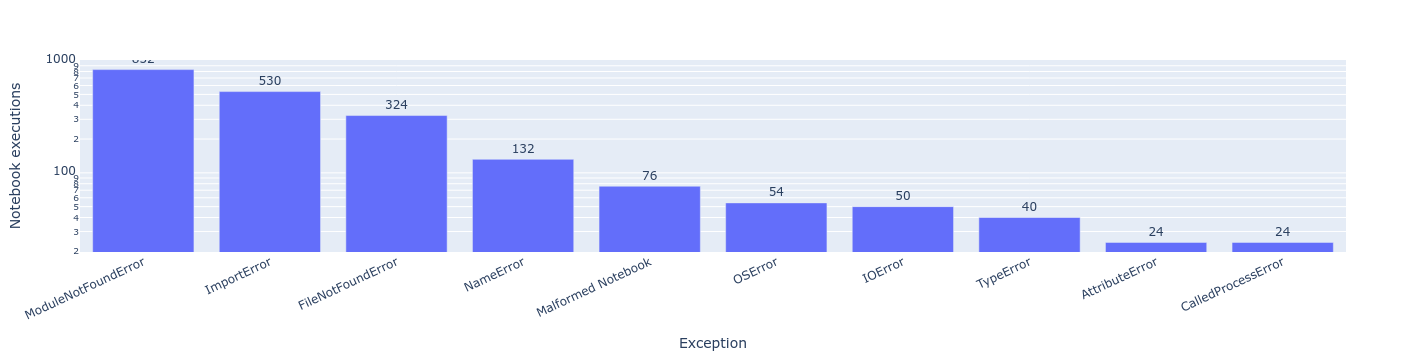

In [9]:
exception_by_reason_df = combined_execution_reason_df['new_reason'].value_counts()
exception_by_reason_df.head()
exception_by_reason_df.columns = ['Exception', 'Notebook executions']
exception_by_reason_df = pd.DataFrame({'Exception':exception_by_reason_df.index, 'Notebook executions':exception_by_reason_df.values})
display_plotlybar(exception_by_reason_df.head(10), 'Exception', 'Notebook executions', 'exception_by_reason')

In [10]:
journal_nb_exception_df = journal_exception_df[['published_year', 'notebooks_count', 'new_reason']]
journal_nb_exception_df.head()

,published_year,notebooks_count,new_reason
0,2021,8,NaN
1,2021,5,FileNotFoundError
2,2021,5,FileNotFoundError
3,2021,3,NaN
4,2021,1,ModuleNotFoundError


In [11]:
modulenotfounderror_per_year_df = journal_nb_exception_df[journal_nb_exception_df['new_reason'] == 'ModuleNotFoundError']
modulenotfounderror_per_year_df.head()
modulenotfounderror_per_published_year_df = modulenotfounderror_per_year_df['published_year'].value_counts().reset_index()
modulenotfounderror_per_published_year_df.columns = ['published_year', 'count']
modulenotfounderror_per_published_year_df.head()

,published_year,count
0,2020,432
1,2019,223
2,2018,69
3,2021,23
4,2016,9


In [12]:
filenotfounderror_per_year_df = journal_nb_exception_df[journal_nb_exception_df['new_reason'] == 'FileNotFoundError']
filenotfounderror_per_year_df.head()
filenotfounderror_per_published_year_df = filenotfounderror_per_year_df['published_year'].value_counts().reset_index()
filenotfounderror_per_published_year_df.columns = ['published_year', 'count']
filenotfounderror_per_published_year_df.head()

,published_year,count
0,2020,164
1,2018,84
2,2019,44
3,2021,20
4,2017,9


In [13]:
importerror_per_year_df = journal_nb_exception_df[journal_nb_exception_df['new_reason'] == 'ImportError']
importerror_per_year_df.head()
importerror_per_published_year_df = importerror_per_year_df['published_year'].value_counts().reset_index()
importerror_per_published_year_df.columns = ['published_year', 'count']
importerror_per_published_year_df.head()

,published_year,count
0,2020,125
1,2018,112
2,2019,96
3,2017,88
4,2015,67


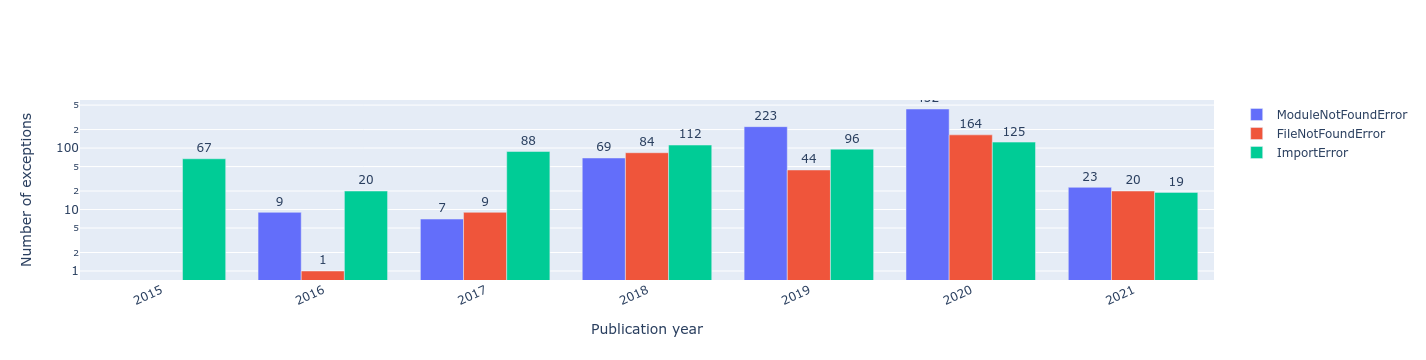

In [14]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=modulenotfounderror_per_published_year_df['published_year'],
    y=modulenotfounderror_per_published_year_df['count'],
    name='ModuleNotFoundError',
))
fig.add_trace(go.Bar(
    x=filenotfounderror_per_published_year_df['published_year'],
    y=filenotfounderror_per_published_year_df['count'],
    name='FileNotFoundError',
))
fig.add_trace(go.Bar(
    x=importerror_per_published_year_df['published_year'],
    y=importerror_per_published_year_df['count'],
    name='ImportError',
))

filename = 'exceptions_per_article_published_year'
xaxis_title = 'Publication year'
yaxis_title = 'Number of exceptions'
fig.update_traces(texttemplate='%{y:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, yaxis_type='log', xaxis_type='date', xaxis_title=xaxis_title, yaxis_title=yaxis_title)    
fig.write_image('Trends/' + filename + '.pdf', scale=1.0)
fig.show()

In [15]:
journal_nb_exception_df = journal_exception_df[['published_year', 'notebooks_count', 'new_reason']]
journal_nb_exception_df.head()

,published_year,notebooks_count,new_reason
0,2021,8,NaN
1,2021,5,FileNotFoundError
2,2021,5,FileNotFoundError
3,2021,3,NaN
4,2021,1,ModuleNotFoundError


In [16]:
temp_df = journal_exception_df[['published_year', 'notebooks_count']]
notebooks_per_year_df = temp_df['published_year'].value_counts().reset_index()
notebooks_per_year_df.columns = ['published_year', 'notebooks_count']
notebooks_per_year_df.head(50)

,published_year,notebooks_count
0,2020,1350
1,2019,725
2,2018,569
3,2017,205
4,2015,131
5,2021,125
6,2016,78
7,2014,10
8,2013,5


In [17]:
temp_df = journal_exception_df[['published_year', 'new_reason']]
exceptions_per_year_df = temp_df.groupby(['published_year'])['new_reason'].size()
exceptions_per_year_df.columns = ['published_year', 'exceptions']
exceptions_per_year_df.head(50)

published_year
2013       5
2014      10
2015     131
2016      78
2017     205
2018     569
2019     725
2020    1350
2021     125
Name: new_reason, dtype: int64

In [18]:
temp_df = journal_exception_df[['published_year', 'notebooks_count']]
notebooks_per_year_df = temp_df.groupby(['published_year'])['notebooks_count'].size()
notebooks_per_year_df.columns = ['published_year', 'notebooks_count']
notebooks_per_year_df.head(50)

published_year
2013       5
2014      10
2015     131
2016      78
2017     205
2018     569
2019     725
2020    1350
2021     125
Name: notebooks_count, dtype: int64

In [19]:
with connect() as session:
    query = (
        "SELECT a.published_date, a.accepted_date, a.received_date, r.notebooks_count "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id and r.notebooks_count > 0"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    notebook_published_year_df = df[['published_year', 'notebooks_count']]

In [20]:
notebook_published_year_df.head()

,published_year,notebooks_count
0,2021,8
1,2021,5
2,2021,3
3,2021,1
4,2021,12


In [21]:
notebooks_per_year_df = notebook_published_year_df.groupby(['published_year'])['notebooks_count'].size()
notebooks_per_year_df.columns = ['published_year', 'notebooks_count']
notebooks_per_year_df.head(50)

published_year
2013      5
2014     10
2015     28
2016     46
2017    100
2018    156
2019    287
2020    419
2021     48
Name: notebooks_count, dtype: int64

In [22]:
with connect() as session:
    query = (
        "SELECT a.published_date, a.accepted_date, a.received_date, r.id as repository_id "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id and r.notebooks_count > 0"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    journal_repository_year_df = df[['repository_id', 'published_year']]

In [23]:
journal_repository_year_df.head()

,repository_id,published_year
0,1,2021
1,7,2021
2,8,2021
3,9,2021
4,12,2021


In [24]:
combined_execution_reason_df = get_combined_reason()
combined_execution_reason_df.head()

,id,repository_id,notebook_id,mode,reason,msg,diff,cell,count,diff_count,timeout,duration,processed,skip,new_reason
3116,3117,40,209,3,ImportError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,4.389466,55,0,ImportError
3117,3118,132,474,3,ImportError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,2.295517,55,0,ImportError
3121,3122,847,3709,3,AttributeError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,5.054708,55,0,AttributeError
3122,3123,1188,5275,3,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,1.405184,55,0,ModuleNotFoundError
3129,3130,459,2231,3,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",,-1.0,0.0,0.0,300.0,3.718115,55,0,ModuleNotFoundError


In [25]:
journal_exception_df = pd.merge(journal_repository_year_df, combined_execution_reason_df, how="left", on=['repository_id'])
journal_exception_df.head()

,repository_id,published_year,id,notebook_id,mode,reason,msg,diff,cell,count,diff_count,timeout,duration,processed,skip,new_reason
0,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,2021,1450.0,9.0,5.0,FileNotFoundError: [Errno 2] No such file or d...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.426490,39.0,0.0,FileNotFoundError
2,7,2021,1452.0,11.0,5.0,FileNotFoundError: [Errno 2] No such file or d...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.417619,39.0,0.0,FileNotFoundError
3,8,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2021,1686.0,17.0,5.0,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",5,5.0,1.0,1.0,300.0,1.399067,39.0,0.0,ModuleNotFoundError


In [26]:
temp_df = journal_exception_df[['published_year', 'new_reason']]
exceptions_per_year_df = temp_df.groupby(['published_year'])['new_reason'].size()
exceptions_per_year_df.columns = ['published_year', 'exceptions']
exceptions_per_year_df.head(50)

published_year
2013       5
2014      10
2015     131
2016      78
2017     205
2018     569
2019     725
2020    1350
2021     125
Name: new_reason, dtype: int64

In [27]:
exceptions_by_year_notebook_df = pd.merge(notebooks_per_year_df, exceptions_per_year_df, on="published_year", how="outer").reset_index()
exceptions_by_year_notebook_df.head()

,published_year,notebooks_count,new_reason
0,2013,5,5
1,2014,10,10
2,2015,28,131
3,2016,46,78
4,2017,100,205


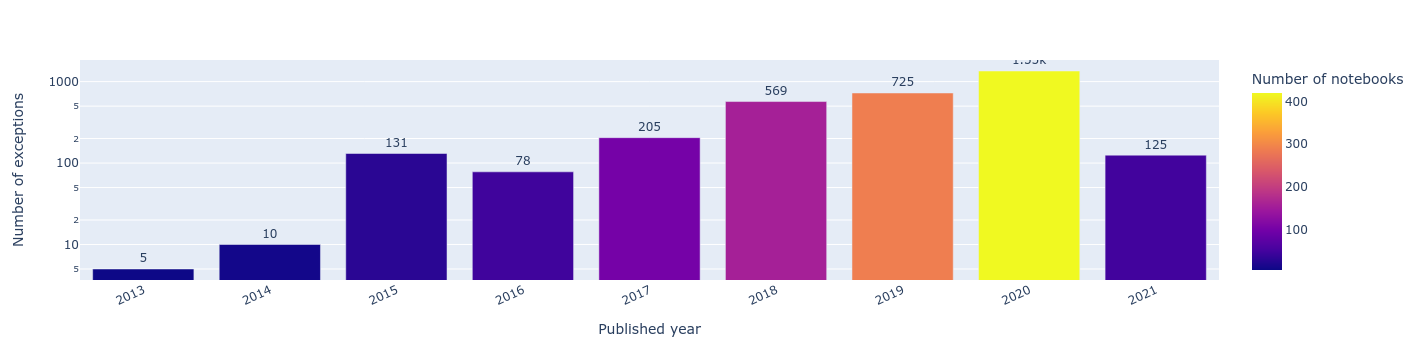

In [28]:
fig = px.bar(exceptions_by_year_notebook_df.head(10), x='published_year', y='new_reason', color='notebooks_count',
             labels=dict(published_year="Published year", new_reason="Number of exceptions", notebooks_count="Number of notebooks"),
        hover_data=['new_reason', 'notebooks_count'], 
)
filename = 'timeline_exceptions_by_year_notebook'
fig = style_bar_chart(fig, filename)
fig.show()

In [29]:
with connect() as session:
    query = (
        "SELECT a.id as article_id, a.subject, r.id as repository_id "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id and r.notebooks_count > 0"
    )
    df = pd.read_sql(query, session.connection())
    journal_subject_df = df[['repository_id', 'article_id', 'subject']]

In [30]:
temp_df = journal_subject_df[['article_id', 'subject']]
articles_per_subject_df = temp_df.groupby(['subject'])['article_id'].size().sort_values(ascending=False).reset_index()
articles_per_subject_df.columns = ['subject', 'article_count']
articles_per_subject_df.head()

,subject,article_count
0,Research Article,269
1,Article,266
2,Neuroscience,43
3,Software,42
4,Data Descriptor,31


In [31]:
journal_subject_exception_df = pd.merge(journal_subject_df, combined_execution_reason_df, how="left", on=['repository_id'])
journal_subject_exception_df.head()

,repository_id,article_id,subject,id,notebook_id,mode,reason,msg,diff,cell,count,diff_count,timeout,duration,processed,skip,new_reason
0,1,1,Software,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,2,Article,1450.0,9.0,5.0,FileNotFoundError: [Errno 2] No such file or d...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.426490,39.0,0.0,FileNotFoundError
2,7,2,Article,1452.0,11.0,5.0,FileNotFoundError: [Errno 2] No such file or d...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.417619,39.0,0.0,FileNotFoundError
3,8,3,Research Article,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,3,Research Article,1686.0,17.0,5.0,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",5,5.0,1.0,1.0,300.0,1.399067,39.0,0.0,ModuleNotFoundError


In [32]:
temp_df = journal_subject_exception_df[['subject', 'new_reason']]
exceptions_per_subject_df = temp_df.groupby(['subject'])['new_reason'].size().sort_values(ascending=False)
exceptions_per_subject_df.columns = ['subject', 'new_reason']
exceptions_per_subject_df.head()

subject
Research Article     1016
Article               771
Data Descriptor       100
Feature Article        99
Collection Review      97
Name: new_reason, dtype: int64

In [33]:
exceptions_by_subject_article_df = pd.merge(articles_per_subject_df, exceptions_per_subject_df, on="subject", how="outer")
exceptions_by_subject_article_df.head()

,subject,article_count,new_reason
0,Research Article,269,1016
1,Article,266,771
2,Neuroscience,43,63
3,Software,42,73
4,Data Descriptor,31,100


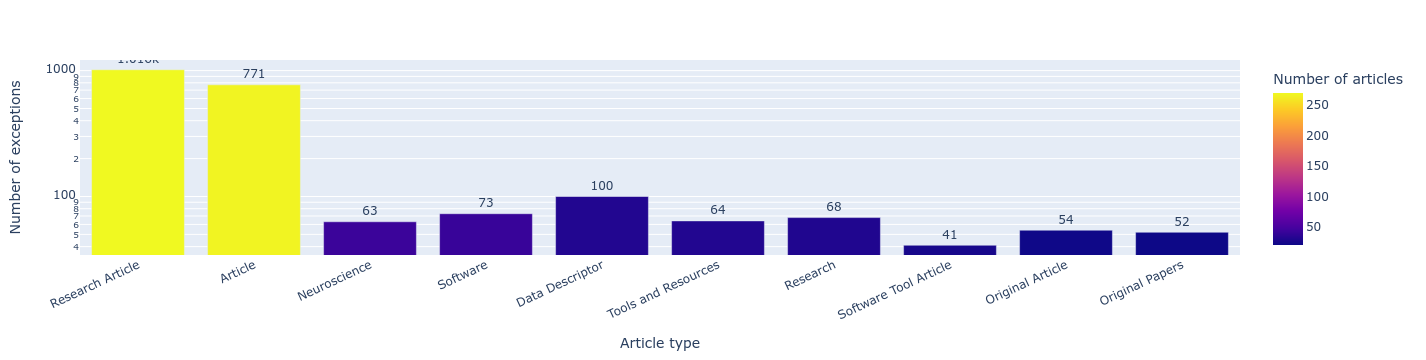

In [34]:
fig = px.bar(exceptions_by_subject_article_df.head(10), x='subject', y='new_reason', color='article_count',
             labels=dict(subject="Article type", new_reason="Number of exceptions", article_count="Number of articles"),
        hover_data=['new_reason', 'article_count'], 
)
filename = 'exceptions_by_subject_article'
fig = style_bar_chart(fig, filename)
fig.show()

In [35]:
journal_df = journal_repository_df[['repository_id', 'journal_abbrev', 'notebooks_count']]
journal_df.head()

,repository_id,journal_abbrev,notebooks_count
0,1,BMC Med Imaging,8
1,7,Nature,5
2,8,PLoS One,3
3,9,PLoS One,1
4,12,PLoS Comput Biol,12


In [36]:
temp_df = journal_df[['journal_abbrev', 'notebooks_count']]
notebooks_per_journal_df = temp_df.groupby(['journal_abbrev'])['notebooks_count'].size().sort_values(ascending=False)
notebooks_per_journal_df.columns = ['journal_abbrev', 'notebooks_count']
notebooks_per_journal_df.head()

journal_abbrev
eLife               137
PLoS One             68
PLoS Comput Biol     68
Nat Commun           58
Sci Data             48
Name: notebooks_count, dtype: int64

In [37]:
journal_exceptions_notebook_df = pd.merge(journal_df, combined_execution_reason_df, how="left", on=['repository_id'])
journal_exceptions_notebook_df.head()

,repository_id,journal_abbrev,notebooks_count,id,notebook_id,mode,reason,msg,diff,cell,count,diff_count,timeout,duration,processed,skip,new_reason
0,1,BMC Med Imaging,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,Nature,5,1450.0,9.0,5.0,FileNotFoundError: [Errno 2] No such file or d...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.426490,39.0,0.0,FileNotFoundError
2,7,Nature,5,1452.0,11.0,5.0,FileNotFoundError: [Errno 2] No such file or d...,"Traceback (most recent call last):\n File ""ru...",0,0.0,1.0,1.0,300.0,1.417619,39.0,0.0,FileNotFoundError
3,8,PLoS One,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,PLoS One,1,1686.0,17.0,5.0,ModuleNotFoundError,"Traceback (most recent call last):\n File ""ru...",5,5.0,1.0,1.0,300.0,1.399067,39.0,0.0,ModuleNotFoundError


In [38]:
temp_df = journal_exceptions_notebook_df[['journal_abbrev', 'new_reason']]
exceptions_per_journal_df = temp_df.groupby(['journal_abbrev'])['new_reason'].size().sort_values(ascending=False)
exceptions_per_journal_df.columns = ['journal_abbrev', 'new_reason']
exceptions_per_journal_df.head()

journal_abbrev
eLife               485
PLoS Comput Biol    316
PLoS One            247
Sci Data            143
Nat Commun          140
Name: new_reason, dtype: int64

In [39]:
exceptions_by_journal_notebooks_df = pd.merge(notebooks_per_journal_df, exceptions_per_journal_df, on="journal_abbrev", how="outer").reset_index()
exceptions_by_journal_notebooks_df.head()

,journal_abbrev,notebooks_count,new_reason
0,eLife,137,485
1,PLoS One,68,247
2,PLoS Comput Biol,68,316
3,Nat Commun,58,140
4,Sci Data,48,143


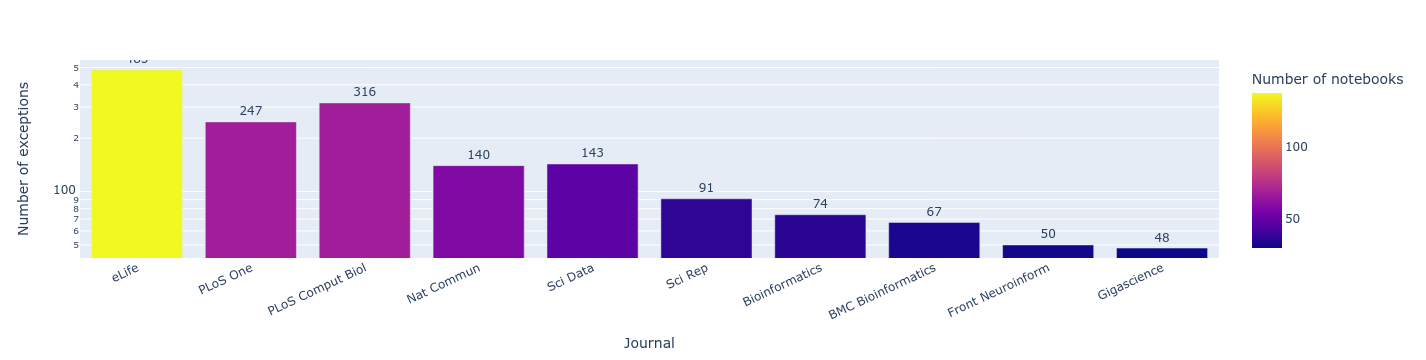

In [41]:
fig = px.bar(exceptions_by_journal_notebooks_df.head(10), x='journal_abbrev', y='new_reason', color='notebooks_count',
             labels=dict(journal_abbrev="Journal", new_reason="Number of exceptions", notebooks_count="Number of notebooks"),
        hover_data=['new_reason', 'notebooks_count'], 
)
filename = 'exceptions_by_journal_notebooks'
fig = style_bar_chart(fig, filename)
fig.show()